In [1]:
import time
start0 = time.time()

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils import resample
from collections import Counter
from sklearn.ensemble import VotingClassifier

upsample_flag = 2   #1: Minor class upsampled; 2: Major class downsampled; 3: Baseline dataset

num_cv = 3
random_state_ = 42

%matplotlib inline
print('Dataset Value: {}' .format(upsample_flag))

Dataset Value: 2


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Preprocessing 

Data for this project was obtained from IBM.

In [2]:
url = 'df_vect.csv'
df = pd.read_csv(url)

In [3]:
df.head()

,MonthlyCharges,TotalCharges,Churn,isFemale,hasPartner,hasDependents,hasPhoneService,hasMultipleLines,hasInternetService,hasOnlineSecurity,hasOnlineBackup,hasDeviceProtection,hasTechSupport,hasStreamingTV,hasStreamingMovies,hasContract,hasPaperlessBilling,hasAutoPaymentMethod
0,29.85,29.85,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0
1,56.95,1889.50,0,0,0,0,1,0,1,1,0,1,0,0,0,1,0,0
2,53.85,108.15,1,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0
3,42.30,1840.75,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,1
4,70.70,151.65,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0


In [4]:
df.shape

(7043, 18)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
MonthlyCharges          7043 non-null float64
TotalCharges            7043 non-null float64
Churn                   7043 non-null int64
isFemale                7043 non-null int64
hasPartner              7043 non-null int64
hasDependents           7043 non-null int64
hasPhoneService         7043 non-null int64
hasMultipleLines        7043 non-null int64
hasInternetService      7043 non-null int64
hasOnlineSecurity       7043 non-null int64
hasOnlineBackup         7043 non-null int64
hasDeviceProtection     7043 non-null int64
hasTechSupport          7043 non-null int64
hasStreamingTV          7043 non-null int64
hasStreamingMovies      7043 non-null int64
hasContract             7043 non-null int64
hasPaperlessBilling     7043 non-null int64
hasAutoPaymentMethod    7043 non-null int64
dtypes: float64(2), int64(16)
memory usage: 990.5 KB


In [6]:
print('The total number of customers who did not churn: {}' .format(df['Churn'].value_counts()[0]))
print('The total number of customers who did churn: {}' .format(df['Churn'].value_counts()[1]))

The total number of customers who did not churn: 5174
The total number of customers who did churn: 1869


In [7]:
df.columns.tolist()

['MonthlyCharges',
 'TotalCharges',
 'Churn',
 'isFemale',
 'hasPartner',
 'hasDependents',
 'hasPhoneService',
 'hasMultipleLines',
 'hasInternetService',
 'hasOnlineSecurity',
 'hasOnlineBackup',
 'hasDeviceProtection',
 'hasTechSupport',
 'hasStreamingTV',
 'hasStreamingMovies',
 'hasContract',
 'hasPaperlessBilling',
 'hasAutoPaymentMethod']

In [8]:
features = df[['MonthlyCharges',
 'TotalCharges',
 'isFemale',
 'hasPartner',
 'hasDependents',
 'hasPhoneService',
 'hasMultipleLines',
 'hasInternetService',
 'hasOnlineSecurity',
 'hasOnlineBackup',
 'hasDeviceProtection',
 'hasTechSupport',
 'hasStreamingTV',
 'hasStreamingMovies',
 'hasContract',
 'hasPaperlessBilling',
 'hasAutoPaymentMethod']]

In [9]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
MonthlyCharges          7043 non-null float64
TotalCharges            7043 non-null float64
isFemale                7043 non-null int64
hasPartner              7043 non-null int64
hasDependents           7043 non-null int64
hasPhoneService         7043 non-null int64
hasMultipleLines        7043 non-null int64
hasInternetService      7043 non-null int64
hasOnlineSecurity       7043 non-null int64
hasOnlineBackup         7043 non-null int64
hasDeviceProtection     7043 non-null int64
hasTechSupport          7043 non-null int64
hasStreamingTV          7043 non-null int64
hasStreamingMovies      7043 non-null int64
hasContract             7043 non-null int64
hasPaperlessBilling     7043 non-null int64
hasAutoPaymentMethod    7043 non-null int64
dtypes: float64(2), int64(15)
memory usage: 935.5 KB


In [10]:
columns_list = df.columns.tolist()

In [11]:
df.head()

,MonthlyCharges,TotalCharges,Churn,isFemale,hasPartner,hasDependents,hasPhoneService,hasMultipleLines,hasInternetService,hasOnlineSecurity,hasOnlineBackup,hasDeviceProtection,hasTechSupport,hasStreamingTV,hasStreamingMovies,hasContract,hasPaperlessBilling,hasAutoPaymentMethod
0,29.85,29.85,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0
1,56.95,1889.50,0,0,0,0,1,0,1,1,0,1,0,0,0,1,0,0
2,53.85,108.15,1,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0
3,42.30,1840.75,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,1
4,70.70,151.65,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0


# Data up/down sampling

In [12]:
df_vect_major = df[df['Churn'] == 0]
df_vect_minor = df[df['Churn'] == 1]

In [13]:
df_vect_major.head()

,MonthlyCharges,TotalCharges,Churn,isFemale,hasPartner,hasDependents,hasPhoneService,hasMultipleLines,hasInternetService,hasOnlineSecurity,hasOnlineBackup,hasDeviceProtection,hasTechSupport,hasStreamingTV,hasStreamingMovies,hasContract,hasPaperlessBilling,hasAutoPaymentMethod
0,29.85,29.85,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0
1,56.95,1889.50,0,0,0,0,1,0,1,1,0,1,0,0,0,1,0,0
3,42.30,1840.75,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,1
6,89.10,1949.40,0,0,0,1,1,1,1,0,1,0,0,1,0,0,1,1
7,29.75,301.90,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0


In [14]:
df_vect_minor.head()

,MonthlyCharges,TotalCharges,Churn,isFemale,hasPartner,hasDependents,hasPhoneService,hasMultipleLines,hasInternetService,hasOnlineSecurity,hasOnlineBackup,hasDeviceProtection,hasTechSupport,hasStreamingTV,hasStreamingMovies,hasContract,hasPaperlessBilling,hasAutoPaymentMethod
2,53.85,108.15,1,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0
4,70.70,151.65,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
5,99.65,820.50,1,1,0,0,1,1,1,0,0,1,0,1,1,0,1,0
8,104.80,3046.05,1,1,1,0,1,1,1,0,0,1,1,1,1,0,1,0
13,103.70,5036.30,1,0,0,0,1,1,1,0,1,1,0,1,1,0,1,1


In [15]:
print("Major Class Shape: {}" .format(df_vect_major.shape))
print("Minor Class Shape: {}" .format(df_vect_minor.shape))

Major Class Shape: (5174, 18)
Minor Class Shape: (1869, 18)


In [16]:
df_major_downsample = resample(df_vect_major, replace=True, n_samples = 1869, random_state=random_state_)

In [17]:
df_major_downsample.shape

(1869, 18)

In [18]:
df_vect_minor.head()

,MonthlyCharges,TotalCharges,Churn,isFemale,hasPartner,hasDependents,hasPhoneService,hasMultipleLines,hasInternetService,hasOnlineSecurity,hasOnlineBackup,hasDeviceProtection,hasTechSupport,hasStreamingTV,hasStreamingMovies,hasContract,hasPaperlessBilling,hasAutoPaymentMethod
2,53.85,108.15,1,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0
4,70.70,151.65,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
5,99.65,820.50,1,1,0,0,1,1,1,0,0,1,0,1,1,0,1,0
8,104.80,3046.05,1,1,1,0,1,1,1,0,0,1,1,1,1,0,1,0
13,103.70,5036.30,1,0,0,0,1,1,1,0,1,1,0,1,1,0,1,1


In [19]:
df_vect_major.head()

,MonthlyCharges,TotalCharges,Churn,isFemale,hasPartner,hasDependents,hasPhoneService,hasMultipleLines,hasInternetService,hasOnlineSecurity,hasOnlineBackup,hasDeviceProtection,hasTechSupport,hasStreamingTV,hasStreamingMovies,hasContract,hasPaperlessBilling,hasAutoPaymentMethod
0,29.85,29.85,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0
1,56.95,1889.50,0,0,0,0,1,0,1,1,0,1,0,0,0,1,0,0
3,42.30,1840.75,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,1
6,89.10,1949.40,0,0,0,1,1,1,1,0,1,0,0,1,0,0,1,1
7,29.75,301.90,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0


In [20]:
df_downsampled = pd.concat([df_vect_minor, df_major_downsample])

In [21]:
df_downsampled.shape

(3738, 18)

In [22]:
df_downsampled.head()

,MonthlyCharges,TotalCharges,Churn,isFemale,hasPartner,hasDependents,hasPhoneService,hasMultipleLines,hasInternetService,hasOnlineSecurity,hasOnlineBackup,hasDeviceProtection,hasTechSupport,hasStreamingTV,hasStreamingMovies,hasContract,hasPaperlessBilling,hasAutoPaymentMethod
2,53.85,108.15,1,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0
4,70.70,151.65,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
5,99.65,820.50,1,1,0,0,1,1,1,0,0,1,0,1,1,0,1,0
8,104.80,3046.05,1,1,1,0,1,1,1,0,0,1,1,1,1,0,1,0
13,103.70,5036.30,1,0,0,0,1,1,1,0,1,1,0,1,1,0,1,1


In [23]:
df_minor_upsample = resample(df_vect_minor, replace=True, n_samples =5174, random_state=random_state_)

In [24]:
df_minor_upsample.shape

(5174, 18)

In [25]:
df_upsampled = pd.concat([df_vect_major, df_minor_upsample])

In [26]:
df_upsampled.shape

(10348, 18)

In [27]:
df_upsampled[df['Churn'] == 0].shape

/Users/gta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(5174, 18)

In [28]:
df_upsampled[df['Churn'] == 1].shape

/Users/gta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(5174, 18)

In [29]:
print(upsample_flag)
if upsample_flag == 1:                          #Upsample
    X = df_upsampled.drop('Churn', axis=1)
    y = df_upsampled['Churn']
elif upsample_flag == 2:                        #Downsample
    X = df_downsampled.drop('Churn', axis=1)
    y = df_downsampled['Churn']
else:                                           #Baseline
    X = df.drop('Churn', axis=1)
    y = df['Churn']

2


In [30]:
X.shape

(3738, 17)

In [31]:
y.shape

(3738,)

In [32]:
def learning_curves(model, X_training_data, y_training_data, model_name, num_k):
    '''
    This function creates testing and cross validation learning curves that can be used
    to assess the performance of a given model.
    
    Inputs:
    model: This is the model object being used. 
    X_training_data: This is the training data that is used for the model training.
    y_training_data: This is the actual response values for the training set.
    model_name: This is the name of the model, as a text string.
    num_k: This is the number of folks to use during the cross validation phase.
    '''
    plt.figure()

    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(model, X_training_data, y_training_data, cv=num_k)

    plt.title("Learning Curves: " + model_name + " With Standard Scaler")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1,
                     color="r")

    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="b")

    plt.plot(train_sizes, 
             train_scores_mean, 
             'o-', 
             color="r", 
             label="Training score")

    plt.plot(train_sizes, 
             test_scores_mean, 
             'o-', color="b", 
             label="Cross-validation score")

    plt.ylim([0.0, 1.25])
    plt.legend(loc="best")
    return plt.show()

In [33]:
def auc_roc_curves(model, X_test_data_, y_test_data_, model_name):
    
    roc_auc  = roc_auc_score(y_test_data_, model.predict(X_test_data_))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_data_)[:,1])
    
    plt.figure()

    plt.plot(fpr, tpr, label= model_name + ' (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: ' + model_name)
    plt.legend(loc="lower right")
    return plt.show()

In [34]:
def lr_coef_curves(model, X_data):
    per_var = np.round(model.coef_[0], decimals = 1)
#     labels = X_data.columns.tolist()
    plt.bar(x = range(1, len(per_var)+1), height=per_var, tick_label = X_data.columns.tolist())
    plt.xlabel('Feature', fontsize = 14)
    plt.ylabel('LR Coefficient Value', fontsize = 14)
    plt.title('LR Coefficient Values', fontsize = 14)
    plt.xticks(rotation=90)
    plt.grid(True)
    return plt.show()

In [35]:
def pca_results_(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
    components.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

def biplot(good_data, reduced_data, pca):
    '''
    Produce a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.
    
    good_data: original data, before transformation.
               Needs to be a pandas dataframe with valid column names
    reduced_data: the reduced data (the first two dimensions are plotted)
    pca: pca object that contains the components_ attribute
    return: a matplotlib AxesSubplot object (for any additional customization)
    
    This procedure is inspired by the script:
    https://github.com/teddyroland/python-biplot
    '''

    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension_1'], y=reduced_data.loc[:, 'Dimension_2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.005)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("Principal Component Plane With Original Feature Projections.", fontsize=16);
    return ax

# Data Scaling Using `StandardScaler`.

In [36]:
standard_scaler = StandardScaler()

In [37]:
print(standard_scaler.fit(X))
X_std = standard_scaler.transform(X)

StandardScaler(copy=True, with_mean=True, with_std=True)


In [38]:
#https://chrisalbon.com/machine_learning/model_evaluation/split_data_into_training_and_test_sets/
#Tl;dr: Split the data set using train_test_split first then apply standard scaler. 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=random_state_, 
                                                    shuffle=True, 
                                                    stratify=y)
#http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
#This means that we don't need to run Stratified_Shuffle_Split.

In [40]:
print(standard_scaler.fit(X_train))
X_train_std_df = standard_scaler.transform(X_train)
X_test_std_df = standard_scaler.transform(X_test)

StandardScaler(copy=True, with_mean=True, with_std=True)


In [41]:
print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (2504, 17)
Shape of X_test: (1234, 17)
Shape of y_train: (2504,)
Shape of y_test: (1234,)


# Part 1: Model development and tuning using `LogisticRegression`.

In [42]:
#LR base with standard scaler
lr = LogisticRegression(random_state=random_state_)
lr.fit(X_train_std_df, y_train)
y_pred_class = lr.predict(X_test_std_df)

print('ROC_AUC Score: {}'. format(roc_auc_score(y_test, y_pred_class)))
print('---')
print('Classification Report:')
print('{}'.format(classification_report(y_test, y_pred_class)))
print('---')
print('LR coef: {}' .format(lr.coef_[0]))
print('---')
print('Confusion Matrix:')
print('{}'.format(confusion_matrix(y_test, y_pred_class)))

ROC_AUC Score: 0.733387358184765
---
Classification Report:
             precision    recall  f1-score   support

          0       0.75      0.69      0.72       617
          1       0.72      0.77      0.74       617

avg / total       0.73      0.73      0.73      1234

---
LR coef: [ 1.17066668 -0.62794497  0.10820854 -0.0450481  -0.0144164  -0.36123059
  0.01578015 -0.02722218 -0.23995474 -0.20583272 -0.01100832 -0.15976149
 -0.00845955  0.04968235 -0.61800002  0.15757827 -0.16635874]
---
Confusion Matrix:
[[428 189]
 [140 477]]


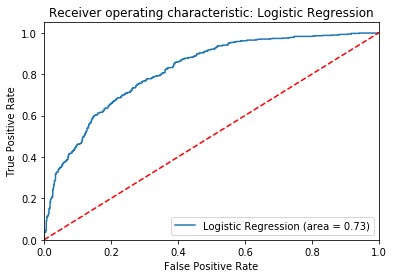

In [43]:
auc_roc_curves(lr, X_test_std_df, y_test, 'Logistic Regression')

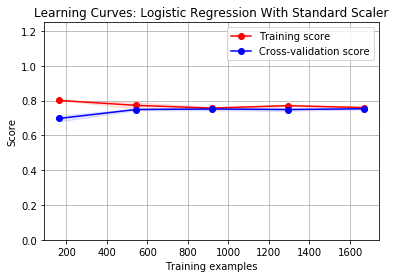

In [44]:
learning_curves(lr, X_train_std_df, y_train, 'Logistic Regression', 3)

In [45]:
#http://scikit-learn.org/0.15/modules/generated/sklearn.cross_validation.cross_val_score.html#sklearn.cross_validation.cross_val_score
lr_std_scores = cross_val_score(lr, X_std, y, cv=3, scoring='recall')
lr_std_scores

array([0.81701445, 0.76404494, 0.76243981])

In [46]:
lr_grid = LogisticRegression(random_state = random_state_)
penalty = ['l1', 'l2']
C = np.logspace(0, 1, 10, 100)
hyperparameters = dict(C=C, penalty=penalty)
grid_results = GridSearchCV(lr_grid, 
                            hyperparameters, 
                            verbose=3, 
                            cv=3, 
                            scoring='recall').fit(X_train_std_df, y_train) #Will output the probability.


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] C=1.0, penalty=l1 ...............................................
[CV] ...... C=1.0, penalty=l1, score=0.7703349282296651, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ...... C=1.0, penalty=l1, score=0.7961630695443646, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ...... C=1.0, penalty=l1, score=0.7889688249400479, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ...... C=1.0, penalty=l2, score=0.7631578947368421, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ...... C=1.0, penalty=l2, score=0.7985611510791367, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ...... C=1.0, penalty=l2, score=0.7865707434052758, total=   0.0s
[CV] C=1.2915496650148839, penalty=l1 ................................
[CV]  C=1.291549

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  C=1.6681005372000588, penalty=l1, score=0.7631578947368421, total=   0.0s
[CV] C=1.6681005372000588, penalty=l1 ................................
[CV]  C=1.6681005372000588, penalty=l1, score=0.7961630695443646, total=   0.0s
[CV] C=1.6681005372000588, penalty=l1 ................................
[CV]  C=1.6681005372000588, penalty=l1, score=0.7889688249400479, total=   0.0s
[CV] C=1.6681005372000588, penalty=l2 ................................
[CV]  C=1.6681005372000588, penalty=l2, score=0.7631578947368421, total=   0.0s
[CV] C=1.6681005372000588, penalty=l2 ................................
[CV]  C=1.6681005372000588, penalty=l2, score=0.7961630695443646, total=   0.0s
[CV] C=1.6681005372000588, penalty=l2 ................................
[CV]  C=1.6681005372000588, penalty=l2, score=0.7865707434052758, total=   0.0s
[CV] C=2.154434690031884, penalty=l1 .................................
[CV]  C=2.154434690031884, penalty=l1, score=0.7631578947368421, total=   0.0s
[CV] C=2.154434

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.9s finished


In [47]:
try:
    print(grid_results.best_params_)
except:
    pass

{'C': 1.0, 'penalty': 'l1'}


In [48]:
try:
    print(grid_results.best_score_) #It is assumed that this combination will yield the best performing model.
except:
    pass

0.7851437699680511


In [49]:
y_pred_class = grid_results.predict(X_test_std_df)

In [50]:
lr_ = grid_results.best_estimator_
print(lr_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [51]:
lr_tuned = grid_results.best_estimator_

In [52]:
#https://stackoverflow.com/questions/49061575/why-when-i-use-gridsearchcv-with-roc-auc-scoring-the-score-is-different-for-gri
lr_tuned.fit(X_train_std_df, y_train)
y_pred_class = lr_tuned.predict(X_test_std_df) #Outputs the class type and not the probabilities.

print('ROC_AUC Score: {}'. format(roc_auc_score(y_test, y_pred_class)))
print('---')
print('Classification Report:')
print('{}'.format(classification_report(y_test, y_pred_class)))
print('---')
print('LR coef: {}' .format(lr_tuned.coef_[0]))
print('---')
print('Confusion Matrix:')
print('{}'.format(confusion_matrix(y_test, y_pred_class)))

ROC_AUC Score: 0.733387358184765
---
Classification Report:
             precision    recall  f1-score   support

          0       0.75      0.69      0.72       617
          1       0.72      0.77      0.74       617

avg / total       0.73      0.73      0.73      1234

---
LR coef: [ 1.15643795 -0.62684443  0.1057439  -0.04310305 -0.01322882 -0.35319568
  0.01346595 -0.01621793 -0.23927622 -0.20353478 -0.00838985 -0.15878264
 -0.00132106  0.04705817 -0.61813927  0.15543392 -0.16455264]
---
Confusion Matrix:
[[428 189]
 [140 477]]


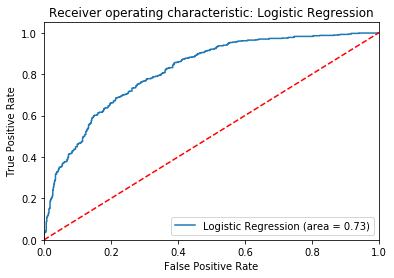

In [53]:
auc_roc_curves(lr_tuned, X_test_std_df, y_test, 'Logistic Regression')

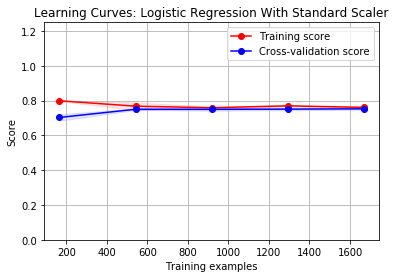

In [54]:
learning_curves(lr_tuned, X_train_std_df, y_train, 'Logistic Regression', 3)

# Part 2: Model development and tuning using `XBGClassifier`.

In [55]:
#https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
#https://github.com/dmlc/xgboost/tree/master/demo/guide-python

#XGB base with standard scaler
xgb_model = XGBClassifier(random_state=random_state_)
xgb_model.fit(X_train_std_df, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [56]:
y_pred_prob = xgb_model.predict(X_test_std_df)
y_pred_class = xgb_model.predict(X_test_std_df)

/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [57]:
print('ROC_AUC Score: {}'. format(roc_auc_score(y_test, y_pred_class)))
print('---')
print('Classification Report:')
print('{}'.format(classification_report(y_test, y_pred_class)))
print('---')
print('Confusion Matrix:')
print('{}'.format(confusion_matrix(y_test, y_pred_class)))

ROC_AUC Score: 0.7471636952998378
---
Classification Report:
             precision    recall  f1-score   support

          0       0.77      0.70      0.74       617
          1       0.73      0.79      0.76       617

avg / total       0.75      0.75      0.75      1234

---
Confusion Matrix:
[[433 184]
 [128 489]]


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

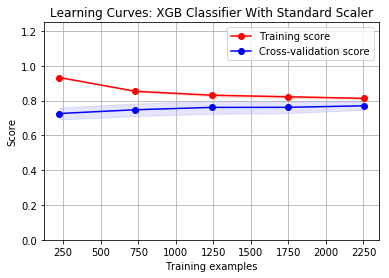

In [58]:
learning_curves(xgb_model, X_train_std_df, y_train, "XGB Classifier", 10)

/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


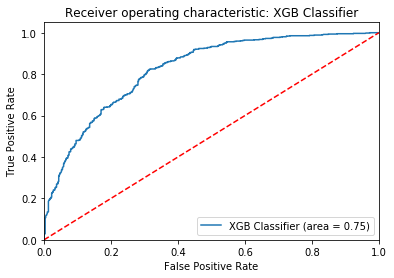

In [59]:
auc_roc_curves(xgb_model, X_test_std_df, y_test, 'XGB Classifier')

In [60]:
# https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
xgb_grid = XGBClassifier(random_state=random_state_)
learning_rate = [0.01, 0.1, 1]
max_depth = [1, 3, 5, 7]
n_estimators = [100, 1000]
hyperparameters = dict(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators)
grid_results = GridSearchCV(xgb_grid, 
                            hyperparameters, 
                            verbose=3, 
                            cv=3, 
                            scoring='recall').fit(X_train_std_df, y_train) #Will output the probability.

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] learning_rate=0.01, max_depth=1, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=1, n_estimators=100, score=0.8779904306220095, total=   0.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=1, n_estimators=100, score=0.8992805755395683, total=   0.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/

[CV]  learning_rate=0.01, max_depth=1, n_estimators=100, score=0.8872901678657075, total=   0.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=1, n_estimators=1000, score=0.80622009569378, total=   0.7s
[CV] learning_rate=0.01, max_depth=1, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=1, n_estimators=1000, score=0.8369304556354916, total=   0.5s
[CV] learning_rate=0.01, max_depth=1, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

[CV]  learning_rate=0.01, max_depth=1, n_estimators=1000, score=0.8105515587529976, total=   0.5s
[CV] learning_rate=0.01, max_depth=3, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, score=0.80622009569378, total=   0.1s
[CV] learning_rate=0.01, max_depth=3, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, score=0.8009592326139089, total=   0.2s
[CV] learning_rate=0.01, max_depth=3, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, score=0.8561151079136691, total=   0.2s
[CV] learning_rate=0.01, max_depth=3, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=3, n_estimators=1000, score=0.7990430622009569, total=   1.5s
[CV] learning_rate=0.01, max_depth=3, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=3, n_estimators=1000, score=0.8009592326139089, total=   1.4s
[CV] learning_rate=0.01, max_depth=3, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=3, n_estimators=1000, score=0.7937649880095923, total=   1.4s
[CV] learning_rate=0.01, max_depth=5, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=5, n_estimators=100, score=0.7990430622009569, total=   0.2s
[CV] learning_rate=0.01, max_depth=5, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=5, n_estimators=100, score=0.8033573141486811, total=   0.3s
[CV] learning_rate=0.01, max_depth=5, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=5, n_estimators=100, score=0.7961630695443646, total=   0.2s
[CV] learning_rate=0.01, max_depth=5, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=5, n_estimators=1000, score=0.7631578947368421, total=   2.1s
[CV] learning_rate=0.01, max_depth=5, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=5, n_estimators=1000, score=0.7889688249400479, total=   2.1s
[CV] learning_rate=0.01, max_depth=5, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=5, n_estimators=1000, score=0.7817745803357314, total=   2.4s
[CV] learning_rate=0.01, max_depth=7, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=7, n_estimators=100, score=0.7607655502392344, total=   0.4s
[CV] learning_rate=0.01, max_depth=7, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=7, n_estimators=100, score=0.7817745803357314, total=   0.4s
[CV] learning_rate=0.01, max_depth=7, n_estimators=100 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=7, n_estimators=100, score=0.7697841726618705, total=   0.3s
[CV] learning_rate=0.01, max_depth=7, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=7, n_estimators=1000, score=0.7535885167464115, total=   2.9s
[CV] learning_rate=0.01, max_depth=7, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.01, max_depth=7, n_estimators=1000, score=0.7697841726618705, total=   2.9s
[CV] learning_rate=0.01, max_depth=7, n_estimators=1000 ..............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

[CV]  learning_rate=0.01, max_depth=7, n_estimators=1000, score=0.7769784172661871, total=   2.8s
[CV] learning_rate=0.1, max_depth=1, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=1, n_estimators=100, score=0.8038277511961722, total=   0.0s
[CV] learning_rate=0.1, max_depth=1, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=1, n_estimators=100, score=0.8369304556354916, total=   0.0s
[CV] learning_rate=0.1, max_depth=1, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=1, n_estimators=100, score=0.8033573141486811, total=   0.0s
[CV] learning_rate=0.1, max_depth=1, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

[CV]  learning_rate=0.1, max_depth=1, n_estimators=1000, score=0.7894736842105263, total=   0.5s
[CV] learning_rate=0.1, max_depth=1, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=1, n_estimators=1000, score=0.8129496402877698, total=   0.5s
[CV] learning_rate=0.1, max_depth=1, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

[CV]  learning_rate=0.1, max_depth=1, n_estimators=1000, score=0.7937649880095923, total=   0.5s
[CV] learning_rate=0.1, max_depth=3, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=3, n_estimators=100, score=0.7894736842105263, total=   0.1s
[CV] learning_rate=0.1, max_depth=3, n_estimators=100 ................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

[CV]  learning_rate=0.1, max_depth=3, n_estimators=100, score=0.8081534772182254, total=   0.1s
[CV] learning_rate=0.1, max_depth=3, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=3, n_estimators=100, score=0.7793764988009593, total=   0.1s
[CV] learning_rate=0.1, max_depth=3, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=3, n_estimators=1000, score=0.7440191387559809, total=   1.1s
[CV] learning_rate=0.1, max_depth=3, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=3, n_estimators=1000, score=0.7482014388489209, total=   1.1s
[CV] learning_rate=0.1, max_depth=3, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=3, n_estimators=1000, score=0.7482014388489209, total=   1.1s
[CV] learning_rate=0.1, max_depth=5, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=100, score=0.7679425837320574, total=   0.2s
[CV] learning_rate=0.1, max_depth=5, n_estimators=100 ................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

[CV]  learning_rate=0.1, max_depth=5, n_estimators=100, score=0.7865707434052758, total=   0.2s
[CV] learning_rate=0.1, max_depth=5, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=100, score=0.7913669064748201, total=   0.2s
[CV] learning_rate=0.1, max_depth=5, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=5, n_estimators=1000, score=0.7368421052631579, total=   1.7s
[CV] learning_rate=0.1, max_depth=5, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=5, n_estimators=1000, score=0.7482014388489209, total=   1.7s
[CV] learning_rate=0.1, max_depth=5, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=5, n_estimators=1000, score=0.7410071942446043, total=   1.7s
[CV] learning_rate=0.1, max_depth=7, n_estimators=100 ................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=7, n_estimators=100, score=0.7416267942583732, total=   0.3s
[CV] learning_rate=0.1, max_depth=7, n_estimators=100 ................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=7, n_estimators=100, score=0.7697841726618705, total=   0.3s
[CV] learning_rate=0.1, max_depth=7, n_estimators=100 ................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=7, n_estimators=100, score=0.7697841726618705, total=   0.3s
[CV] learning_rate=0.1, max_depth=7, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=7, n_estimators=1000, score=0.7248803827751196, total=   2.4s
[CV] learning_rate=0.1, max_depth=7, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.1, max_depth=7, n_estimators=1000, score=0.750599520383693, total=   2.4s
[CV] learning_rate=0.1, max_depth=7, n_estimators=1000 ...............


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

[CV]  learning_rate=0.1, max_depth=7, n_estimators=1000, score=0.7290167865707434, total=   2.4s
[CV] learning_rate=1, max_depth=1, n_estimators=100 ..................
[CV]  learning_rate=1, max_depth=1, n_estimators=100, score=0.7799043062200957, total=   0.0s
[CV] learning_rate=1, max_depth=1, n_estimators=100 ..................
[CV]  learning_rate=1, max_depth=1, n_estimators=100, score=0.7961630695443646, total=   0.0s
[CV] learning_rate=1, max_depth=1, n_estimators=100 ..................
[CV]  learning_rate=1, max_depth=1, n_estimators=100, score=0.7721822541966427, total=   0.0s
[CV] learning_rate=1, max_depth=1, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

[CV]  learning_rate=1, max_depth=1, n_estimators=1000, score=0.7464114832535885, total=   0.5s
[CV] learning_rate=1, max_depth=1, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=1, n_estimators=1000, score=0.7769784172661871, total=   0.5s
[CV] learning_rate=1, max_depth=1, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

[CV]  learning_rate=1, max_depth=1, n_estimators=1000, score=0.750599520383693, total=   0.5s
[CV] learning_rate=1, max_depth=3, n_estimators=100 ..................
[CV]  learning_rate=1, max_depth=3, n_estimators=100, score=0.7296650717703349, total=   0.1s
[CV] learning_rate=1, max_depth=3, n_estimators=100 ..................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

[CV]  learning_rate=1, max_depth=3, n_estimators=100, score=0.7122302158273381, total=   0.1s
[CV] learning_rate=1, max_depth=3, n_estimators=100 ..................
[CV]  learning_rate=1, max_depth=3, n_estimators=100, score=0.7146282973621103, total=   0.1s
[CV] learning_rate=1, max_depth=3, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=3, n_estimators=1000, score=0.7344497607655502, total=   1.1s
[CV] learning_rate=1, max_depth=3, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=3, n_estimators=1000, score=0.7410071942446043, total=   1.1s
[CV] learning_rate=1, max_depth=3, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=3, n_estimators=1000, score=0.7338129496402878, total=   1.1s
[CV] learning_rate=1, max_depth=5, n_estimators=100 ..................
[CV]  learning_rate=1, max_depth=5, n_estimators=100, score=0.715311004784689, total=   0.2s
[CV] learning_rate=1, max_depth=5, n_estimators=100 ..................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

[CV]  learning_rate=1, max_depth=5, n_estimators=100, score=0.7362110311750599, total=   0.2s
[CV] learning_rate=1, max_depth=5, n_estimators=100 ..................
[CV]  learning_rate=1, max_depth=5, n_estimators=100, score=0.7194244604316546, total=   0.2s
[CV] learning_rate=1, max_depth=5, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=5, n_estimators=1000, score=0.715311004784689, total=   1.6s
[CV] learning_rate=1, max_depth=5, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=5, n_estimators=1000, score=0.7338129496402878, total=   1.7s
[CV] learning_rate=1, max_depth=5, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=5, n_estimators=1000, score=0.7314148681055156, total=   1.7s
[CV] learning_rate=1, max_depth=7, n_estimators=100 ..................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=7, n_estimators=100, score=0.7177033492822966, total=   0.3s
[CV] learning_rate=1, max_depth=7, n_estimators=100 ..................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=7, n_estimators=100, score=0.7482014388489209, total=   0.3s
[CV] learning_rate=1, max_depth=7, n_estimators=100 ..................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=7, n_estimators=100, score=0.7290167865707434, total=   0.3s
[CV] learning_rate=1, max_depth=7, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=7, n_estimators=1000, score=0.7129186602870813, total=   1.9s
[CV] learning_rate=1, max_depth=7, n_estimators=1000 .................


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=1, max_depth=7, n_estimators=1000, score=0.7314148681055156, total=   1.9s
[CV] learning_rate=1, max_depth=7, n_estimators=1000 .................
[CV]  learning_rate=1, max_depth=7, n_estimators=1000, score=0.7362110311750599, total=   1.9s


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.0min finished


In [61]:
print(grid_results.best_params_)

{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 100}


In [62]:
print(grid_results.best_score_) #It is assumed that this combination will yield the best performing model.

0.8881789137380192


In [63]:
xgb_ = grid_results.best_estimator_
print(xgb_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)


In [64]:
xgb_tuned = grid_results.best_estimator_

In [65]:
xgb_tuned.fit(X_train_std_df, y_train)
y_pred_class = xgb_tuned.predict(X_test_std_df)

/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [66]:
print('ROC_AUC Score: {}'. format(roc_auc_score(y_test, y_pred_class)))
print('---')
print('Classification Report:')
print('{}'.format(classification_report(y_test, y_pred_class)))
print('---')
print('Confusion Matrix:')
print('{}'.format(confusion_matrix(y_test, y_pred_class)))

ROC_AUC Score: 0.7188006482982172
---
Classification Report:
             precision    recall  f1-score   support

          0       0.82      0.56      0.66       617
          1       0.67      0.88      0.76       617

avg / total       0.74      0.72      0.71      1234

---
Confusion Matrix:
[[344 273]
 [ 74 543]]


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

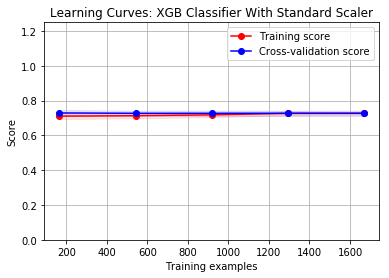

In [67]:
learning_curves(xgb_tuned, X_train_std_df, y_train, "XGB Classifier", 3)

/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


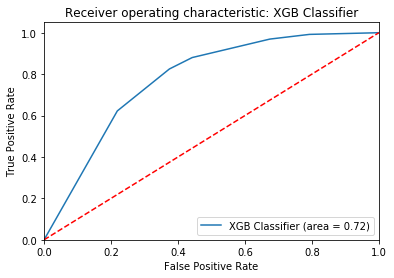

In [68]:
auc_roc_curves(xgb_tuned, X_test_std_df, y_test, 'XGB Classifier')

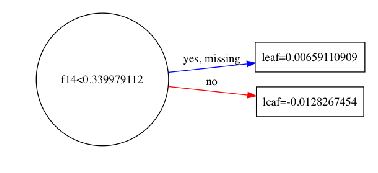

In [69]:
from xgboost import plot_tree
plot_tree(xgb_tuned, num_trees=4, rankdir='LR')
plt.show()

In [70]:
X_train_std_df[0][-4]

-0.8215329500147065

# Part 3: Model development and tuning using `SVC`.

In [71]:
svc_model = SVC(random_state=42, probability=True)
svc_model.fit(X_train_std_df, y_train)
y_pred_class = svc_model.predict(X_test_std_df)
#http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

In [72]:
print('ROC_AUC Score: {}'. format(roc_auc_score(y_test, y_pred_class)))
print('---')
print('Classification Report:')
print('{}'.format(classification_report(y_test, y_pred_class)))
print('---')
print('Confusion Matrix:')
print('{}'.format(confusion_matrix(y_test, y_pred_class)))

ROC_AUC Score: 0.7382495948136143
---
Classification Report:
             precision    recall  f1-score   support

          0       0.77      0.68      0.72       617
          1       0.71      0.80      0.75       617

avg / total       0.74      0.74      0.74      1234

---
Confusion Matrix:
[[417 200]
 [123 494]]


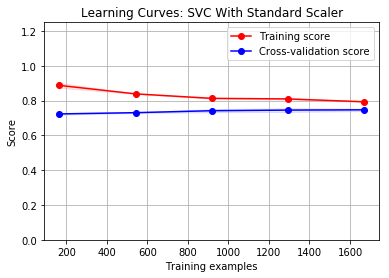

In [73]:
learning_curves(svc_model, X_train_std_df, y_train, "SVC", 3)

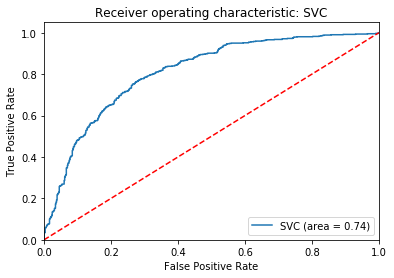

In [74]:
auc_roc_curves(svc_model, X_test_std_df, y_test, 'SVC')

In [75]:
svc_grid = SVC(random_state=random_state_, probability=True)
C = [0.001, 0.10, 0.1, 10]
gamma = [1e-2, 1e-3, 1e-4]
kernel = ['rbf', 'poly'] 
hyperparameters = dict(C=C, gamma=gamma, kernel=kernel)
grid_results = GridSearchCV(svc_grid, 
                            hyperparameters, 
                            verbose=3, 
                            cv=3, 
                            scoring='recall').fit(X_train_std_df, y_train) #Will output the probability.

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV]  C=0.001, gamma=0.01, kernel=rbf, score=0.8444976076555024, total=   0.6s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  C=0.001, gamma=0.01, kernel=rbf, score=0.8537170263788969, total=   0.5s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  C=0.001, gamma=0.01, kernel=rbf, score=0.8513189448441247, total=   0.5s
[CV] C=0.001, gamma=0.01, kernel=poly ................................
[CV]  C=0.001, gamma=0.01, kernel=poly, score=0.9952153110047847, total=   0.3s
[CV] C=0.001, gamma=0.01, kernel=poly ................................
[CV]  C=0.001, gamma=0.01, kernel=poly, score=0.9808153477218226, total=   0.3s
[CV] C=0.001, gamma=0.01, kernel=poly ................................
[CV]  C=0.001, gamma=0.01, kernel=poly, score=0.9904076738609112, total=   0.3s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV]  C=0.001, gamma=0.001, kernel=rbf, score=0.8851674641148325, total=   0.5s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV]  C=0.001, gamma=0.001, kernel=rbf, score=0.8729016786570744, total=   0.5s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV]  C=0.001, gamma=0.001, kernel=rbf, score=0.882494004796163, total=   0.5s
[CV] C=0.001, ga

[CV]  C=10, gamma=0.01, kernel=poly, score=0.9043062200956937, total=   0.3s
[CV] C=10, gamma=0.01, kernel=poly ...................................
[CV]  C=10, gamma=0.01, kernel=poly, score=0.9040767386091128, total=   0.3s
[CV] C=10, gamma=0.01, kernel=poly ...................................
[CV]  C=10, gamma=0.01, kernel=poly, score=0.8848920863309353, total=   0.3s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV]  C=10, gamma=0.001, kernel=rbf, score=0.8253588516746412, total=   0.4s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV]  C=10, gamma=0.001, kernel=rbf, score=0.8489208633093526, total=   0.4s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV]  C=10, gamma=0.001, kernel=rbf, score=0.8345323741007195, total=   0.4s
[CV] C=10, gamma=0.001, kernel=poly ..................................
[CV]  C=10, gamma=0.001, kernel=poly, score=0.9952153110047847, total=   0.3s
[CV] C=10, gamma=0.001, kernel=pol

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   32.2s finished


In [76]:
print(grid_results.best_params_)

{'C': 0.001, 'gamma': 0.01, 'kernel': 'poly'}


In [77]:
print(grid_results.best_score_) #It is assumed that this combination will yield the best performing model.

0.9888178913738019


In [78]:
svc_ = grid_results.best_estimator_
print(svc_)

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='poly',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)


In [79]:
svc_tuned = grid_results.best_estimator_

In [80]:
svc_tuned.fit(X_train_std_df, y_train)

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='poly',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [81]:
svc_tuned.fit(X_train_std_df, y_train)
y_pred_class = svc_tuned.predict(X_test_std_df) #Outputs the class type and not the probabilities.

In [82]:
print('ROC_AUC Score: {}'. format(roc_auc_score(y_test, y_pred_class)))
print('---')
print('Classification Report:')
print('{}'.format(classification_report(y_test, y_pred_class)))
print('---')
print('Confusion Matrix:')
print('{}'.format(confusion_matrix(y_test, y_pred_class)))

ROC_AUC Score: 0.5583468395461912
---
Classification Report:
             precision    recall  f1-score   support

          0       0.92      0.13      0.22       617
          1       0.53      0.99      0.69       617

avg / total       0.72      0.56      0.46      1234

---
Confusion Matrix:
[[ 79 538]
 [  7 610]]


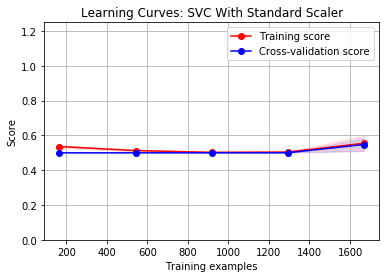

Elapsed time: 0.04 min


In [83]:
start1 = time.time()

learning_curves(svc_tuned, X_train_std_df, y_train, "SVC", 3)

end1 = time.time()
print('Elapsed time: {0:.2f} min' .format((end1 - start1)/60))

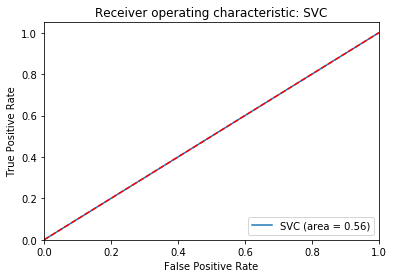

Elapsed time: 0.00 min


In [84]:
start2 = time.time()

auc_roc_curves(svc_tuned, X_test_std_df, y_test, 'SVC')

end2 = time.time()
print('Elapsed time: {0:.2f} min' .format((end2 - start2)/60))

In [89]:
estimators = []
model1 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                            penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
                            verbose=0, warm_start=False)
estimators.append(('logistic', model1))

model2 = SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
             decision_function_shape='ovr', degree=3, gamma=0.01, kernel='poly',
             max_iter=-1, probability=True, random_state=42, shrinking=True,
             tol=0.001, verbose=False)
estimators.append(('svm', model2))

model3 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
                       max_depth=1, min_child_weight=1, missing=None, n_estimators=100,
                       n_jobs=1, nthread=None, objective='binary:logistic',
                       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                       seed=None, silent=True, subsample=1)
estimators.append(('xgb', model3))

ensemble = VotingClassifier(estimators)
y_pred_class = ensemble.fit(X_train_std_df, y_train).predict(X_test_std_df)

print('ROC_AUC Score: {}'. format(roc_auc_score(y_test, y_pred_class)))
print('---')
print('Classification Report:')
print('{}'.format(classification_report(y_test, y_pred_class)))
print('---')
print('Confusion Matrix:')
print('{}'.format(confusion_matrix(y_test, y_pred_class)))

ROC_AUC Score: 0.7179902755267423
---
Classification Report:
             precision    recall  f1-score   support

          0       0.83      0.55      0.66       617
          1       0.66      0.89      0.76       617

avg / total       0.75      0.72      0.71      1234

---
Confusion Matrix:
[[339 278]
 [ 70 547]]


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gta/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

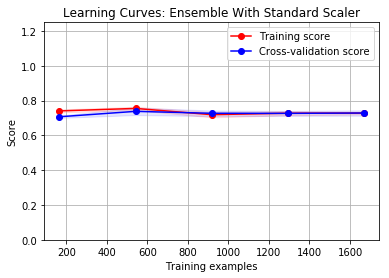

In [90]:
learning_curves(ensemble, X_train_std_df, y_train, "Ensemble", 3)